In [51]:
import uproot
import awkward as ak
import numpy as np
from coffea import nanoevents
import matplotlib.pyplot as plt

In [12]:
%load_ext autoreload
%autoreload 2

In [16]:
import TaggerInference

In [22]:
nanoevents.PFNanoAODSchema.nested_index_items["FatJetAK15_pFCandsIdxG"] = (
    "FatJetAK15_nConstituents",
    "JetPFCandsAK15",
)
nanoevents.PFNanoAODSchema.mixins["FatJetAK15"] = "FatJet"
nanoevents.PFNanoAODSchema.mixins["FatJetAK15SubJet"] = "FatJet"
nanoevents.PFNanoAODSchema.mixins["SubJet"] = "FatJet"
nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

In [119]:
pf_variables = [
    "pfcand_pt_log_nopuppi",
    "pfcand_e_log_nopuppi",
    "pfcand_etarel",
    "pfcand_phirel",
    "pfcand_isEl",
    "pfcand_isMu",
    "pfcand_isGamma",
    "pfcand_isChargedHad",
    "pfcand_isNeutralHad",
    "pfcand_abseta",
    "pfcand_charge",
    "pfcand_VTX_ass",
    "pfcand_lostInnerHits",
    "pfcand_normchi2",
    "pfcand_quality",
    "pfcand_dz",
    "pfcand_dzsig",
    "pfcand_dxy",
    "pfcand_dxysig",
    "pfcand_btagEtaRel",
    "pfcand_btagPtRatio",
    "pfcand_btagPParRatio",
    "pfcand_btagSip3dVal",
    "pfcand_btagSip3dSig",
    "pfcand_btagJetDistVal",
]

sv_variables = [
    "sv_pt_log",
    "sv_mass",
    "sv_etarel",
    "sv_phirel",
    "sv_abseta",
    "sv_ntracks",
    "sv_normchi2",
    "sv_dxy",
    "sv_dxysig",
    "sv_d3d",
    "sv_d3dsig",
    # "sv_costhetasvpv",
]

In [6]:
data_dir = "../../../../data/pku_inputs_debug/"

events_dnn = uproot.open(f"{data_dir}/output_numEvent40.root:deepntuplizer/tree").arrays()

fname = f"{data_dir}/nano_skim_0-1.root"
events_coffea = uproot.open(f"{fname}:Events").arrays(library="np")

In [24]:
events_pf = nanoevents.NanoEventsFactory.from_root(
    f"{data_dir}/miniaod_20ul_35914-0.root",
    schemaclass=nanoevents.PFNanoAODSchema,
).events()

/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1929 branches) at 0x7fe65984bcd0>, taking first instance
  warnings.warn(
/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1929 branches) at 0x7fe65984bcd0>, taking first instance
  warnings.warn(
/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1929 branches) at 0x7fe65984bcd0>, taking first instance
  warnings.warn(
/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (1929 branches) at 0x7f

In [85]:
pnet_vars = TaggerInference.runInferenceTriton(
    "./tagger_resources/",
    events_pf,
    ak15=False,
    all_outputs=True,
)

Running inference for Jet 1
size of input = 500


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Inference took 7.7s
Running inference for Jet 2
size of input = 500


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]

Inference took 8.1s
Total time taken: 16.3s


In [ ]:
tagger_inputs, tagger_outputs, pnet_vars_list = TaggerInference.runInferenceTriton(
    "./tagger_resources/",
    events_pf,
    ak15=False,
    all_outputs=True,
)

In [34]:
npfs = 128
nsvs = 10
idx_pfnano = 7
idx_dnn = 20


def pad_val(array, var_length):
    return (
        ak.pad_none(array, var_length, axis=1, clip=True).to_numpy().filled(fill_value=0)
    ).astype(np.float32)


def get_dnn(branch, idx=idx_dnn):
    if "pfcand" in branch:
        x = pad_val(events_dnn[branch], npfs)
        y = x[idx]
        # y = np.delete(y,28)
        # y = np.append(y,0.)
    elif "sv" in branch:
        y = pad_val(events_dnn[branch], nsvs)[idx]
    else:
        y = events_dnn[branch][idx]
    return y


def get_coffea(branch, idx=idx_pfnano):
    x = events_coffea[branch][idx]
    if "pfcand" in branch:
        sorter = np.copy(events_coffea["pfcand_pt_log_nopuppi"][idx])
        sorter[sorter == 0] = -100
        x = x[ak.argsort(sorter, ascending=False)]

    elif "sv" in branch:
        x = x[ak.argsort(events_coffea["sv_dxysig"][idx], ascending=False)]

    return x

In [174]:
for var in pf_variables:
    x = get_dnn(var)
    y = get_coffea(var)

    if not np.allclose(x, y, rtol=1e-2):
        not_close = np.isclose(x, y, rtol=1e-2) == False
        # print(x[not_close],y[not_close])
        print(var, x[not_close], y[not_close])

pfcand_phirel [-0.00747986 -0.00318325 -0.00660122  0.01332091  0.03255197] [-0.0078125  -0.00341797 -0.00683594  0.01318359  0.03222656]
pfcand_normchi2 [999. 999. 999. 999. 999. 999. 999. 999. 999. 999.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
pfcand_dz [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
pfcand_dzsig [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pfcand_dxy [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
pfcand_dxysig [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [62]:
for var in sv_variables:
    x = get_dnn(var)
    y = get_coffea(var)

    if not np.allclose(x, y, rtol=1e-2):
        not_close = np.isclose(x, y, rtol=1e-2) == False
        # print(x[not_close],y[not_close])
        print(var, x[not_close], y[not_close])

In [43]:
pf_pt_unc = pad_val((events_pf.FatJet.pt * (1.0 - events_pf.FatJet.rawFactor)), 2)
pf_eta = pad_val(events_pf.FatJet.eta, 2)

(array([25.,  6.,  2.,  6.,  4.,  5.,  3.,  7.,  9., 13.]),
 array([4.77424968e-04, 9.90266949e-02, 1.97575971e-01, 2.96125233e-01,
        3.94674510e-01, 4.93223786e-01, 5.91773033e-01, 6.90322340e-01,
        7.88871586e-01, 8.87420893e-01, 9.85970140e-01]),
 <BarContainer object of 10 artists>)

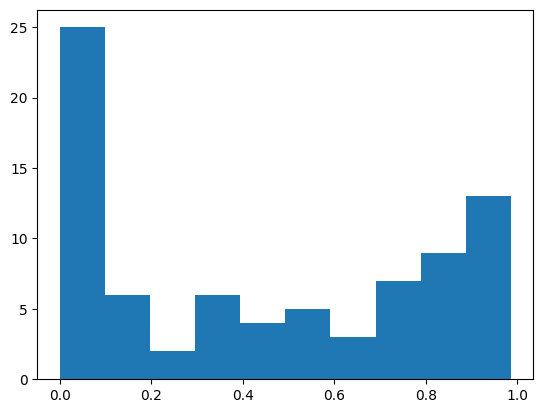

In [56]:
# plt.hist(events_dnn["pfMassDecorrelatedInclParticleTransformerV1JetTags_probHWqqWqq2c"])
plt.hist(
    events_dnn["pfMassDecorrelatedInclParticleTransformerV1DiscriminatorsJetTags_HWW4q3qvsQCD"]
)

(array([178.,  68.,  43.,  56.,  59.,  65.,  77.,  97., 130., 194.]),
 array([4.38614807e-04, 1.00302897e-01, 2.00167179e-01, 3.00031453e-01,
        3.99895728e-01, 4.99760032e-01, 5.99624276e-01, 6.99488580e-01,
        7.99352884e-01, 8.99217129e-01, 9.99081433e-01]),
 <BarContainer object of 10 artists>)

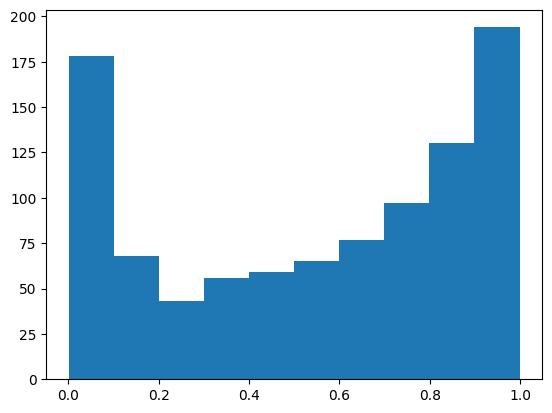

In [87]:
plt.hist(pnet_vars["ak8FatJetParTMD_THWW4q"].reshape(-1))

In [98]:
matches = []
scores = []
scores_non_match = []

for i, (dnn_pt, dnn_eta) in enumerate(zip(events_dnn["fj_pt"], events_dnn["fj_eta"])):
    find_match = np.isclose(dnn_pt, pf_pt_unc, rtol=0.001) * np.isclose(dnn_eta, pf_eta, rtol=0.001)
    if np.any(find_match):
        where = np.where(find_match)
        matches.append([i, [where[0][0], where[1][0]]])
        scores.append(
            [
                events_dnn[
                    "pfMassDecorrelatedInclParticleTransformerV1DiscriminatorsJetTags_HWW4q3qvsQCD"
                ][i],
                pnet_vars["ak8FatJetParTMD_THWW4q"][matches[-1][1][0], matches[-1][1][1]],
            ]
        )

        if not np.isclose(scores[-1][0], scores[-1][1], rtol=0.1):
            print(scores[-1])
            scores_non_match.append(matches[-1])

scores = np.array(scores)

[0.09782160073518753, 0.1337427]
[0.0580739788711071, 0.052580483]
[0.0922127515077591, 0.081338435]


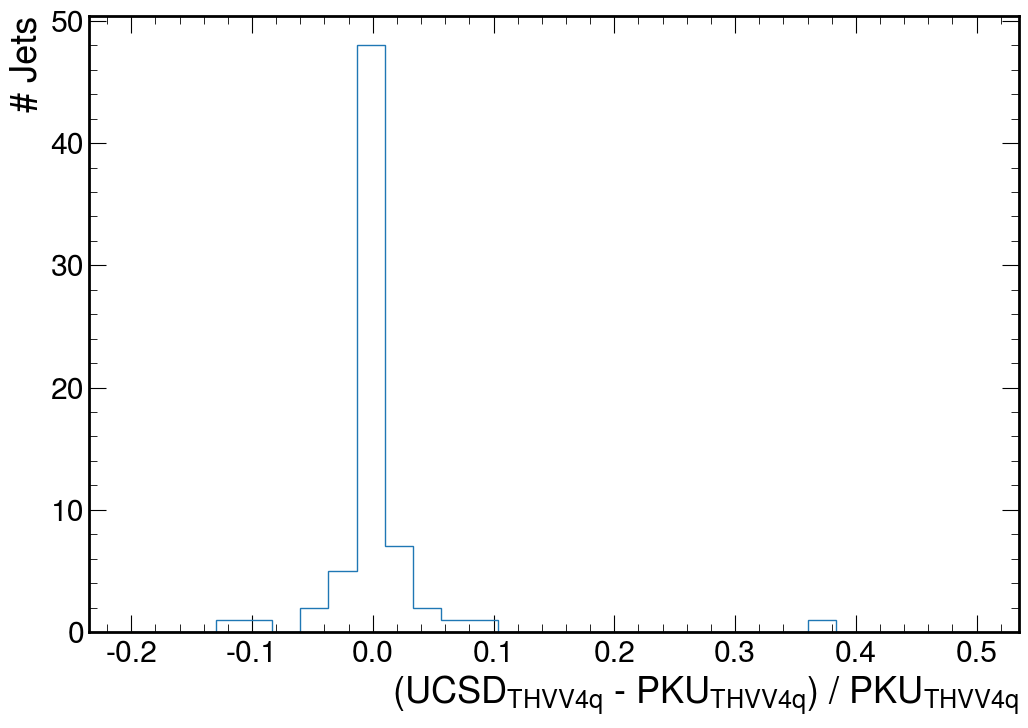

In [154]:
import mplhep as hep

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)
hep.style.use("CMS")

plt.figure(figsize=(12, 8))
_ = plt.hist(
    -(scores[:, 0] - scores[:, 1]) / scores[:, 0], np.linspace(-0.2, 0.5, 31), histtype="step"
)
plt.xlabel(r"(UCSD$_{THVV4q}$ - PKU$_{THVV4q}$) / PKU$_{THVV4q}$")
plt.ylabel("# Jets")
plt.savefig("../../../plots/TaggerAnalysis/23Jan31/ucsd_pku_diff.pdf")

In [99]:
scores_non_match

[[12, [7, 1]], [29, [12, 1]], [41, [19, 0]]]

In [129]:
for dnn_idx, (event_idx, jet_idx) in matches:
    print(dnn_idx)
    for var in pf_variables:
        x = get_dnn(var, idx=dnn_idx)
        y = feature_dicts[jet_idx][var][event_idx]

        if not np.allclose(x, y, rtol=0.1):
            not_close = np.isclose(x, y, rtol=0.1) == False
            # print(x[not_close],y[not_close])
            print(var, x[not_close], y[not_close])

0
1
pfcand_dz [-0.0052832   0.00445801] [0. 0.]
pfcand_dxy [-0.00097595 -0.00562988] [0. 0.]
2
pfcand_dz [-0.01578125  0.00819824 -0.00551758] [0. 0. 0.]
pfcand_dxy [0.01048828 0.04054688 0.01212891] [0. 0. 0.]
3
pfcand_etarel [-0.00016221] [-0.00018311]
pfcand_dz [-0.00674316 -0.02310547] [0. 0.]
pfcand_dxy [-0.00116577 -0.01321289] [0. 0.]
4
5
pfcand_dz [0.00477051] [0.]
pfcand_dxy [0.01984375] [0.]
6
7
pfcand_e_log_nopuppi [1.2725575 1.6709108] [1.6709819 1.2725798]
pfcand_etarel [-0.7895428  -0.20413673] [-0.20410156 -0.7895508 ]
pfcand_phirel [-0.26324382  0.09155215] [ 0.09155273 -0.2631836 ]
pfcand_isGamma [0. 1.] [1. 0.]
pfcand_isChargedHad [1. 0.] [0. 1.]
pfcand_abseta [0.55903804 1.1444441 ] [1.1445312  0.55908203]
pfcand_charge [1. 0.] [0. 1.]
pfcand_VTX_ass [1. 7.] [7. 1.]
pfcand_lostInnerHits [ 2. -1.] [-1.  2.]
pfcand_normchi2 [  1. 999.] [999.   1.]
pfcand_quality [5. 0.] [0. 5.]
pfcand_dz [ 2.346665    0.         -0.00248047 -0.02578125 -0.085      -0.01554688
  0.07316

In [141]:
var = "pfcand_pt_log_nopuppi"
print(get_dnn(var, 22)[:30])
print(feature_dicts[matches[19][1][1]][var][matches[19][1][0]][:30])

[ 4.710093    3.66276     3.4764209   2.862201    2.6805933   2.572135
  2.3602643   2.3401518   2.3010213   2.1102133   1.9542458   1.7956581
  1.495359    1.4615178   1.451504    0.9100211   0.81785065  0.46670228
  0.05694138 -0.00981362 -0.04442957 -0.1224325  -0.15896368 -0.43394294
 -0.43394294 -0.53454214 -0.56328464 -0.62064487 -0.63436246 -0.65107596]
[ 4.710093    3.66276     3.4764209   2.862201    2.6805933   2.572135
  2.3602643   2.3401518   2.3010213   2.1102133   1.9542458   1.7956581
  1.495359    1.4615178   1.451504    0.9100211   0.81785065  0.46670228
  0.05694138 -0.00981362 -0.04442957 -0.1224325  -0.15896368 -0.43394294
 -0.43394294 -0.53454214 -0.56328464 -0.62064487 -0.63436246 -0.65107596]


In [142]:
var = "pfcand_etarel"
print(get_dnn(var, 22)[:30])
print(feature_dicts[matches[19][1][1]][var][matches[19][1][0]][:30])

[ 0.03950679 -0.25713313 -0.29723442  0.02192819  0.04554951 -0.29906547
  0.06294501  0.38943195  0.0625788  -0.00297499  0.03950679  0.39712262
  0.14095032  0.4335618  -0.27892327 -0.34209657 -0.2800219   0.44564724
 -0.49005032 -0.1732682   0.40041876  0.15266943  0.3011725   0.1314286
 -0.27306378  0.5915866   0.35976815 -0.09526289 -0.12803984  0.5716276 ]
[ 0.03955078 -0.25708008 -0.29711914  0.02197266  0.0456543  -0.29907227
  0.06298828  0.3894043   0.0625     -0.00292969  0.03955078  0.3972168
  0.14086914  0.4338379  -0.2788086  -0.34204102 -0.2800293   0.44555664
 -0.48999023 -0.17333984  0.40063477  0.15258789  0.3010254  -0.27294922
  0.13134766  0.59155273  0.35961914 -0.09521484 -0.12792969  0.5715332 ]


In [143]:
var = "sv_pt_log"
print(get_dnn(var, 12))
print(feature_dicts[1][var][7])

[0.6745696 3.8985136 3.3861008 0.        0.        0.        0.
 0.        0.        0.       ]
[0.6744182 3.898811  0.        0.        0.        0.        0.
 0.        0.        0.       ]


In [125]:
for dnn_idx, (event_idx, jet_idx) in matches:
    print(dnn_idx)
    for var in sv_variables:
        x = get_dnn(var, idx=dnn_idx)
        y = feature_dicts[jet_idx][var][event_idx]

        if not np.allclose(x, y, rtol=1e-2):
            not_close = np.isclose(x, y, rtol=1e-2) == False
            # print(x[not_close],y[not_close])
            print(var, x[not_close], y[not_close])

0
1
2
3
4
5
6
7
sv_pt_log [4.1673923] [0.]
sv_mass [2.2032306] [0.]
sv_etarel [0.04238558] [0.]
sv_phirel [0.08595258] [0.]
sv_abseta [1.3909664] [0.]
sv_ntracks [4.] [0.]
sv_normchi2 [0.9616302] [0.]
sv_dxy [0.0571454] [0.]
sv_dxysig [2.07726] [0.]
sv_d3d [0.12650827] [0.]
sv_d3dsig [2.1622627] [0.]
9
10
sv_pt_log [2.357462] [0.]
sv_mass [1.3914834] [0.]
sv_etarel [0.07270426] [0.]
sv_phirel [-0.25949168] [0.]
sv_abseta [0.91660833] [0.]
sv_ntracks [4.] [0.]
sv_normchi2 [0.12759401] [0.]
sv_dxy [0.01304499] [0.]
sv_dxysig [0.8801947] [0.]
sv_d3d [0.0172443] [0.]
sv_d3dsig [0.80103964] [0.]
11
12
sv_pt_log [3.3861008] [0.]
sv_mass [1.6262714] [0.]
sv_etarel [-0.23770802] [0.]
sv_phirel [-0.2534712] [0.]
sv_abseta [0.1776451] [0.]
sv_ntracks [5.] [0.]
sv_normchi2 [2.1762261] [0.]
sv_dxy [0.06690023] [0.]
sv_dxysig [2.5420141] [0.]
sv_d3d [0.06736898] [0.]
sv_d3dsig [2.524094] [0.]
13
14
sv_pt_log [4.3108296] [0.]
sv_mass [4.749898] [0.]
sv_etarel [-0.04078645] [0.]
sv_phirel [0.16748762

In [121]:
svs_label = "FatJetSVs"

jet_svs = events_pf.SV[
    events_pf[svs_label].sVIdx[
        (events_pf[svs_label].sVIdx != -1) * (events_pf[svs_label].jetIdx == 1)
    ]
]

# sort by dxy significance
jet_svs = jet_svs[ak.argsort(jet_svs.dxySig, ascending=False)]

In [123]:
jet_svs[7]

<PFCandArray [PFCand, PFCand] type='2 * pFCand'>

In [100]:
tagger_inputs = TaggerInference.runInferenceTriton(
    "./tagger_resources/",
    events_pf,
    ak15=False,
    all_outputs=True,
)

In [103]:
feature_dicts = TaggerInference.runInferenceTriton(
    "./tagger_resources/",
    events_pf,
    ak15=False,
    all_outputs=True,
)